In [0]:
import numpy as np 
import pandas as pd 

# Plotting
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch

import sklearn
import re
import html
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ast import literal_eval
from sklearn.metrics import confusion_matrix
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer,classification_report

# 1. Data cleaning

In [15]:
# load the meta data from the CSV file 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

#show 10 lines of the new dataframe
print (df.shape)
df.head(10)

(45774, 5)
(34809, 5)


,title,doi,abstract,publish_time,authors
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen
5,The infant airway microbiome in health and dis...,10.1101/012070,the nasopharynx (np) is a reservoir for microb...,2014-12-02,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...
6,Using heterogeneity in the population structur...,10.1101/017178,"abstractin 2013, u.s. swine producers were con...",2015-03-27,Eamon B. O’Dea; Harry Snelson; Shweta Bansal
7,"Big city, small world: Density, contact rates,...",10.1101/018481,macroscopic descriptions of populations common...,2015-04-27,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...
8,MERS-CoV recombination: implications about the...,10.1101/020834,recombination is a process that unlinks neighb...,2015-06-12,Gytis Dudas; Andrew Rambaut
9,On the causes of evolutionary transition:trans...,10.1101/027722,a pattern in which nucleotide transitions are ...,2015-09-28,Arlin Stoltzfus; Ryan W. Norris


# 2. Data Visualization and Exploratory Data Analysis

## Problem Statement

Recently, COVID-19 is spreading all over the world, and researchers are still working on finding an efficient way to solve the issues that bring by this disease. Although the treatment of COVID-19 is not yet discovered, the number of relevant research about coronavirus is large. Thus, it is important to find a way to extract useful information. It would be helpful if data analytic technology can help the experts in the medical and healthcare system to improve their work efficiency.

This project is mainly about how to find a more efficient way to sort the most relevant information from a huge dataset. First, we need to figure out what kind of information is more relevant to 'COVID-19'. To do this, we first need to do some research about the current types of coronavirus.

In [0]:
def virus_name(tw_list):
    '''
    The function take takes a single tweet as imput and analyze the keyword in it. 
    It compares the word frequency of each tweet in the key word list for each party.
    The output is the politican party name of the single twitter. 
    If a tweet is identified as more than one party attribute, it choose the most common party names.
    '''
    tw = tw_list
    # keywords of each party
    alphacoronavirus =["HCoV-229E","Alphacoronaviruses",'Alpha-CoV'] #defining parties
    betacoronavirus=['OC43','HCoV-OC43', ]
    NMERS=['MERS-CoV','MERS','coronavirus 2012','2012','Middle East respiratory syndrome','HCoV-EMC']
    SARS=['SARS-CoV ','SARS-classic','SARS-CoV-2','SARS','2019-nCoV','coronavirus 2019','2019','2002','outbreak','severe acute respiratory syndrome','acute respiratory syndrome','bat']

   
    # we only defined words in lowercase format, since all words in tweet line are converted to lowercase
    a = []
        
    for word in alphacoronavirus:   
        if word in tw:
            a.append('alphacoronavirus')
        
    for word in betacoronavirus:
        if word in tw:
            a.append('betacoronavirus')
           
    for word in NMERS:
        if word in tw:
            a.append('NMERS')

    for word in SARS:
        if word in tw:
            a.append('SARS')            

    if len(a) > 1:
        most_common = max(set(a), key=a.count)
        a = []
        a.append(most_common)
    elif len(a) == 0:
        a.append('None')
        
    return a

In [0]:
# put each abstract in to corresponding virus list
virus_list = []
virus_alpha_list= []
virus_beta_list = []
virus_nmers_list = []
virus_sars_list = []

for i in range(len(df)): 
    try:
      virus_determinant = virus_name(df['abstract'][i])[0]
      virus_list.append(virus_determinant)

      if virus_determinant == 'alphacoronavirus':
          virus_alpha_list.append(df['abstract'][i])
      elif virus_determinant == 'betacoronavirus':
          virus_beta_list.append(df['abstract'][i])
      elif virus_determinant == 'NMERS':
          virus_nmers_list.append(df['abstract'][i])
      elif virus_determinant == 'SARS':
          virus_sars_list.append(df['abstract'][i]) 
    except:
      virus_list.append('None')
      continue


In [18]:
print(len(virus_list))

34809


Based on the 349809 research papers, human coronavirus are mainly in the following types: 

*  Alphacoronavirus
*  Betacoronavirus
*  Middle East respiratory syndrome-related coronavirus (MERS-CoV)
*  Severe acute respiratory syndrome coronavirus(SARS-CoV)

The first figure shows the distribution of the researches on a specific Virus type. According to the plot, we can find that the recent researches mainly focus on MERS-CoV and SARS-CoV. Moreover, there are fewer researches about MERS-CoV than SARS-CoV. The current research shows that the two species (MERS-CoV and SARS-CoV) produce potentially severe symptoms. Therefore, there might be more research focus on this two conornvirus specie.

Secondly, we plot the word cloud to see the keyword for MERS-CoV and SARS-CoV virus.

Next, we will focus on the SARS-CoV since the disease COROV-19 is caused by a novel type of SARS-CoV virus. 

Coronaviruses were first discovered in the 1930s. Since then, the number of research papers about Coronaviruses is larger and larger. How to find useful information from those huge numbers of researches become an important problem. Considering the current situation of COROV-19, we need to find an efficient way that can help to find relative and useful information as soon as possible. Therefore, the goal is to find a way to find the most relative pieces of information from a wide range of previous research.


Text(0.5, 1.0, 'Distribution of the Researches on a specific Virus type')

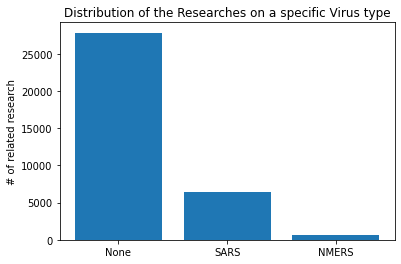

In [0]:
# plot a histogram
x = Counter(virus_list)
l = range(len(x.keys()))
plt.bar(l, x.values(), align='center')
plt.xticks(l, x.keys())
plt.ylabel('# of related research')
plt.title('Distribution of the Researches on a specific Virus type')

In [0]:
# split a list containing tweets into a list containing words
def split_list_into_word(lst):
    word_list = []
    templist = []
    for i in range(len(lst)):
        templist = lst[i].split()
        for word in templist:
            word_list.append(word)
    return word_list

Below is the worldCloud for Keywords of Research about MERS. We can find that the key words includes MERS, COV, patient, infection, etc.

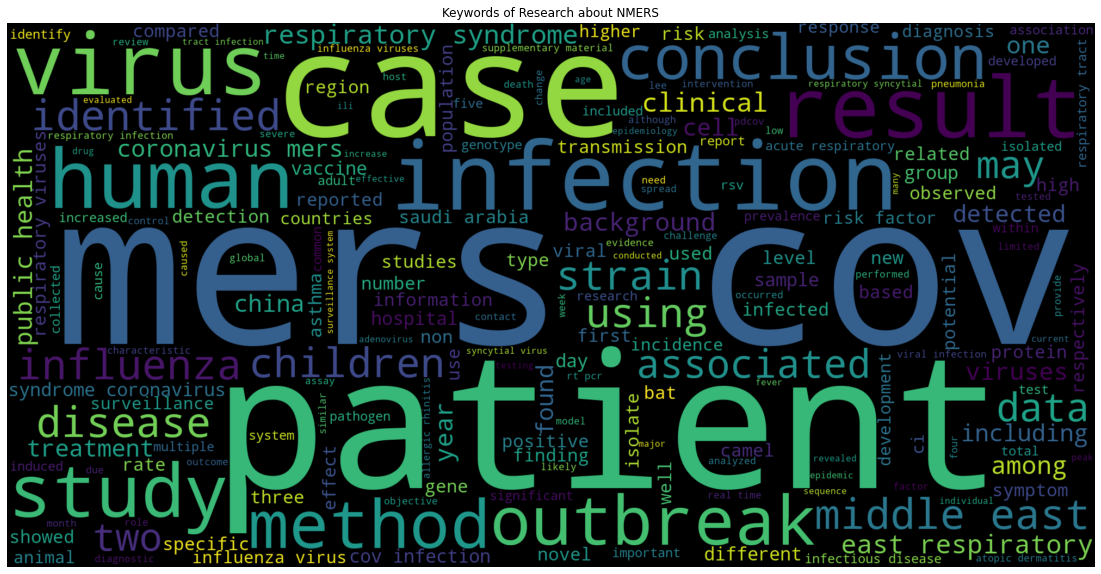

In [0]:
nmers_wordlist = split_list_into_word(virus_nmers_list)
wl_space_split = " ".join(nmers_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Research about NMERS')
plt.axis("off")
plt.show()

Below is the word cloud for Keywords of Research about SARS. We can find keywords that include sars, cov, acute, respiratory, outbreak, etc.

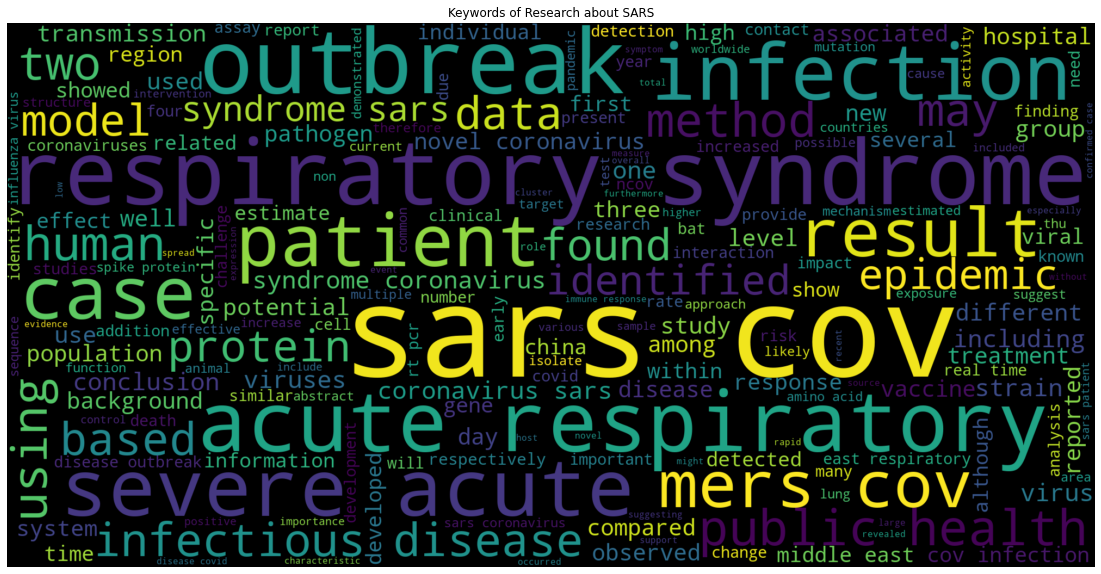

In [0]:
sars_wordlist = split_list_into_word(virus_sars_list)
wl_space_split = " ".join(sars_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Research about SARS')
plt.axis("off")
plt.show()

# 3. Model selection and fitting to data
Next, I will focus on the SARS-CoV since the disease COROV-19 is caused by a novel type of SARS-CoV virus.

I will first split the dataset. Then I will use the words in 'abstract' data to train multiple models. The model will predict the type of coronavirus that each research is mainly talking about. The goal is to find the best model that can help to select the researches that are more relevant to COVID-19.

In [19]:
# add a column in df from virus_list
column_values = pd.Series(virus_list)
df['virus'] = column_values.values
df.head()

,title,doi,abstract,publish_time,authors,virus
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,None
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,SARS
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,None
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,None
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,SARS


## Model preparation - Prepare and split dataset
First, the dataset is splited into features and targets from metadata.csv file.

We will use train_test_split with test size of 0.3 to put 70% of our data into training, and 30% into testing. The random_state is set so the results are repeatable

In [57]:
X = df[['abstract']]
y = df[['virus']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)
print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: (24366, 1)
Shape of X_test: (10443, 1)
Shape of y_train: (24366, 1)
Shape of y_test: (10443, 1)


## Term Frequency–Inverse Document Frequency(TF-IDF)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect2 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
vect2.fit_transform(X_train.abstract)
X_train_vec2 = vect2.transform(X_train.abstract)
print(X_train_vec2.shape)
X_test_vec2 = vect2.transform(X_test.abstract)

(24366, 83810)


## Model implementation - training multiple models

### Logistic Regression
Now, we will use our training set to train (fit) a Logistic Regression model from sklearn.

In [0]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()

# Prediction on X_train_vec = train error
from sklearn.model_selection import cross_val_predict
# specify to ignore warning messages
import warnings
warnings.filterwarnings("ignore") 
model_logistic.fit(X_train_vec2, y_train)
# Prediction on validation(30%) set within Classified_tweets
prediction = model_logistic.predict(X_test_vec2)
# Accuracy of prediction on validation(30%) set within Classified_tweets
score_valid_error = accuracy_score(y_test, prediction)
print('The accuracy of the Logistic Regressio model on TF-IDF test dataset is {0:.5f}%'.format(score_valid_error*100))

The accuracy of the Logistic Regressio model on TF-IDF test dataset is 70.39165%


### k-Nearest Neighbor (k-NN)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
# Fit k-NN model to make prediction on X_test_vec(WF)
model_knn.fit(X_train_vec2, y_train)
# Prediction on validation(30%) set within Classified_tweets
prediction = model_knn.predict(X_test_vec2)
# Accuracy of prediction on validation(30%) set within Classified_tweets
score_valid_error = accuracy_score(y_test, prediction)
print('The accuracy of the k-NN model on TF-IDF test dataset is {0:.5f}%'.format(score_valid_error*100))

The accuracy of the k-NN model on TF-IDF test dataset is 79.06732%


### Naive Bayes
MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification

In [39]:
from sklearn import naive_bayes
model_naive_bayes = naive_bayes.MultinomialNB()
# Fit naive Bayes model to make prediction on X_test_vec(WF)
model_naive_bayes.fit(X_train_vec2, y_train)
# Prediction on validation(30%) set within Classified_tweets
prediction_NB = model_naive_bayes.predict(X_test_vec2)
# Accuracy of prediction on validation(30%) set within Classified_tweets
score_valid_error = accuracy_score(y_test, prediction_NB)
print('The accuracy of the naive Bayes model on TF-IDF test dataset is {0:.5f}%'.format(score_valid_error*100))

The accuracy of the naive Bayes model on TF-IDF test dataset is 65.27818%


### Decision Trees
Let's try to separate these two classes by training an Sklearn decision tree.

In [40]:
from sklearn.tree import DecisionTreeClassifier
model_decisiontree = DecisionTreeClassifier()
from sklearn.metrics import accuracy_score
# Fit Decision Tree model to make prediction on X_test_vec(TF-IDF)
model_decisiontree.fit(X_train_vec2, y_train)
# Prediction on validation(30%) set within Classified_tweets
prediction2 = model_decisiontree.predict(X_test_vec2)
# Accuracy of prediction on validation(30%) set within Classified_tweets
score_valid_error = accuracy_score(y_test, prediction2)
print('The accuracy of the Decision tree model on TF-IDF test dataset is {0:.5f}%'.format(score_valid_error*100))

The accuracy of the Decision tree model on TF-IDF test dataset is 70.64062%


## Tune Hyperparameters
From the previous result, we can observe that the Naive Bayes model performs worst in our case. Decision Trees and Logistic Regression model shows a similar performance. The k-NN model performs much better than other models in the TF-IDF dataset. Then we can run the grid search on the k-NN model to find the parameters that maximize the testing accuracy.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
best_model = model
best_params = {}
best_accuracy = 0
best_std = 0
for n_neighbors in [2,5,8,10,20,30,40]:
    for weights in ['uniform','distance']:
        
        model = KNeighborsClassifier(n_neighbors = n_neighbors, weights=weights)
        accuracy = np.zeros(10)
        np_idx = 0
        import warnings
        warnings.filterwarnings("ignore") 
        model.fit(X_train_vec2, y_train)         
        # Prediction on validation(30%) set within Classified_tweets
        prediction = model.predict(X_test_vec2)
        # Accuracy of prediction on validation(30%) set within Classified_tweets
        ACC = accuracy_score(y_test, prediction)
        print('n_neighbors: {}, weights: {}'.format(n_neighbors,weights))
        #print('slover: {}'.format(solver))
        print('The accuracy of the knn model on TF-IDF test dataset is {0:.5f}%'.format(ACC*100))

        accuracy = ACC*100
        #np_idx += 1
        
        if  accuracy > best_accuracy:
            best_model = model
            best_params = {'n_neighbors':n_neighbors, 'weights':weights}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)

n_neighbors: 2, weights: uniform
The accuracy of the knn model on TF-IDF test dataset is 77.76501%
n_neighbors: 2, weights: distance
The accuracy of the knn model on TF-IDF test dataset is 71.32050%
n_neighbors: 5, weights: uniform
The accuracy of the knn model on TF-IDF test dataset is 79.06732%
n_neighbors: 5, weights: distance
The accuracy of the knn model on TF-IDF test dataset is 78.90453%
n_neighbors: 8, weights: uniform
The accuracy of the knn model on TF-IDF test dataset is 79.84296%
n_neighbors: 8, weights: distance
The accuracy of the knn model on TF-IDF test dataset is 79.61314%
n_neighbors: 10, weights: uniform
The accuracy of the knn model on TF-IDF test dataset is 79.96744%
n_neighbors: 10, weights: distance
The accuracy of the knn model on TF-IDF test dataset is 79.85253%
n_neighbors: 20, weights: uniform
The accuracy of the knn model on TF-IDF test dataset is 80.17811%
n_neighbors: 20, weights: distance
The accuracy of the knn model on TF-IDF test dataset is 80.14938%
n

From the above, we can find the best model is the K-NN model. From the grid search, we can observe that the best parameter in TF-IDF is the follows:

n_neighbors: 30, weights: 'uniform'

Therefore, the best model is the k-NN model in TF-IDF, with n_neighbors=30, weights=uniform.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=30, weights='uniform')
# Fit k-NN model to make prediction on X_test_vec(WF)
model_knn.fit(X_train_vec2, y_train)
# Prediction on validation(30%) set within Classified_tweets
prediction = model_knn.predict(X_test_vec2)
# Accuracy of prediction on validation(30%) set within Classified_tweets
score_valid_error = accuracy_score(y_test, prediction)
print('The accuracy of the k-NN model on TF-IDF test dataset is {0:.5f}%'.format(score_valid_error*100))

The accuracy of the k-NN model on TF-IDF test dataset is 80.22599%


# 4. Deriving insights about policy and guidance to tackle the outbreak based on model findings

From part 3, we can find the model with the best performance is the k-NN model with parameters: n_neighbors=30, weights=uniform. 

The complete process includes: 
 

*   Splited the text in the dataset into features
*   Convert the features into Frequency–Inverse Document Frequency(TF-IDF). TF-IDF, which reflects how important a word is.

*  Use K=NN model with parameters: n_neighbors=30, weights=uniform to predict which type of virus that is the main topic of each input.

Using this finding, we can easily find the research paper that is most related to the COVID-19 from their abstract. 

## Apply optimal model in research title data 
In the previous step, we fitted the model with the research's abstract data. Now, we can see how well the model is when applying the optimal model to the research's title. 


In [20]:
X2 = df[['title']]
y2 = df[['virus']]

from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.3,random_state=101)
print("Shape of X_train:",X_train2.shape)
print("Shape of X_test:",X_test2.shape)
print("Shape of y_train:",y_train2.shape)
print("Shape of y_test:",y_test2.shape)

Shape of X_train: (24366, 1)
Shape of X_test: (10443, 1)
Shape of y_train: (24366, 1)
Shape of y_test: (10443, 1)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
vect.fit_transform(X_train2.title)
X_train_vec = vect.transform(X_train2.title)
X_test_vec = vect.transform(X_test2.title)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=30, weights='uniform')
# specify to ignore warning messages
import warnings
warnings.filterwarnings("ignore") 
# Fit k-NN model to make prediction on X_test_vec(WF)
model_knn.fit(X_train_vec, y_train2)
# Prediction on validation(30%) set within Classified_tweets
prediction = model_knn.predict(X_test_vec)
# Accuracy of prediction on validation(30%) set within Classified_tweets
score_valid_error = accuracy_score(y_test2, prediction)
print('The accuracy of the optimal k-NN model on TF-IDF test dataset is {0:.5f}%'.format(score_valid_error*100))

The accuracy of the optimal k-NN model on TF-IDF test dataset is 79.95787%


In [21]:
print(classification_report(y_test2,prediction))

              precision    recall  f1-score   support

       NMERS       0.00      0.00      0.00       200
        None       0.80      1.00      0.89      8349
        SARS       1.00      0.00      0.00      1894

    accuracy                           0.80     10443
   macro avg       0.60      0.33      0.30     10443
weighted avg       0.82      0.80      0.71     10443




Since the novel type of SARS is the virus that causes COVID-19, the previous research about SARS might be more helpful than other research about coronavirus. With the research papers which prediction result is SARS, we can pay more attention to these papers.

From part 3, we can find the model with the best performance is the k-NN model with parameters: n_neighbors=30, weights=uniform. Applying this optimal model to train the words in the abstract can achieve a accuracy of 80.22599%, which shows the model works well on predict the main topic (conronavirus type) of a research. Using this finding, we can easily find the research paper that is most related to the COVID-19 from their abstract. 

Mot just limits to the abstract, when applying the optimal model to the research's title, this optimal model also performs well. The accuracy is 79.95% when we apply the optimal k-NN model to the title data and predict whether the research is related to the COVID-19.

Considering the current situation of COROV-19, it is important to find an efficient way that can help us to find relative and useful information as soon as possible. Using the optimal K-NN model can help to achieve the goal. This model can take the natural language such as the research paper's abstract, full content, or title as input, then predict whether it is relevant to SARS (the virus causes COVID-19), MERS, or another type of coronavirus.

The good result of accuracy shows that the optimal model performs well in predicting which type of coronavirus that the input words are talking about. Thus, we can use this model as a tool to increase the efficiency of finding relative research information about COVID-19. This model could be useful in sorting researches that are more relevant to COVID-19. It can also reduce the time-wasting in searching for useful information.

Moreover, the data are not limited to the title, abstract, or content of the research paper. Other resources like webpage can also apply this model. The model can also help increase the efficiency of searching relevant information about COVID-19.